kvector: [ 0.          0.06283185  0.12566371  0.18849556  0.25132741  0.31415927
  0.37699112  0.43982297  0.50265482  0.56548668  0.62831853  0.69115038
  0.75398224  0.81681409  0.87964594  0.9424778   1.00530965  1.0681415
  1.13097336  1.19380521  1.25663706  1.31946891  1.38230077  1.44513262
  1.50796447  1.57079633  1.63362818  1.69646003  1.75929189  1.82212374
  1.88495559  1.94778745  2.0106193   2.07345115  2.136283    2.19911486
  2.26194671  2.32477856  2.38761042  2.45044227  2.51327412  2.57610598
  2.63893783  2.70176968  2.76460154  2.82743339  2.89026524  2.95309709
  3.01592895  3.0787608   3.14159265 -3.0787608  -3.01592895 -2.95309709
 -2.89026524 -2.82743339 -2.76460154 -2.70176968 -2.63893783 -2.57610598
 -2.51327412 -2.45044227 -2.38761042 -2.32477856 -2.26194671 -2.19911486
 -2.136283   -2.07345115 -2.0106193  -1.94778745 -1.88495559 -1.82212374
 -1.75929189 -1.69646003 -1.63362818 -1.57079633 -1.50796447 -1.44513262
 -1.38230077 -1.31946891 -1.25663706 -1.193

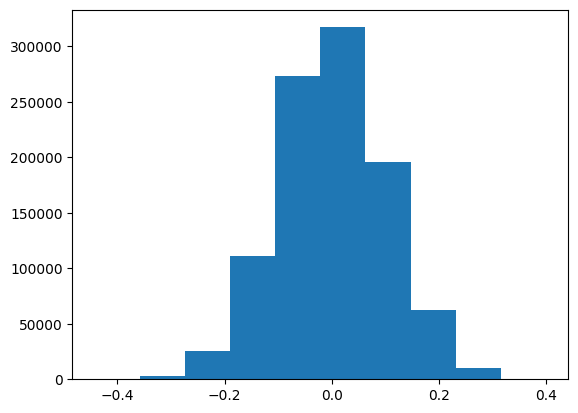

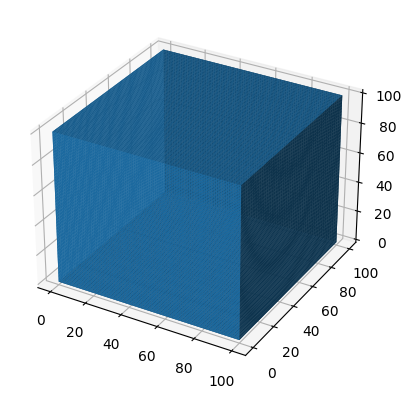

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.fft import fftn, ifftn
import imageio

def k_vector(npoints):
    k1 = np.arange(npoints/2+1)
    k2 = np.arange(-npoints/2+1, 0)
    
    kvector = 2*np.pi/ npoints* np.concatenate([k1, k2])
    print("kvector:",kvector, '\n')
    return kvector

def pk_vector_delta(kvector, k0, dk0):
    
    npoints = len(kvector)
    shape = [npoints] * dim
    kk = np.zeros(shape)
    
      
    for i, j, k in itertools.product(range(npoints), range(npoints), range(npoints)):
        kk[i, j, k] = np.sqrt(kvector[i]**2 + kvector[j]**2 + kvector[k]**2)
               
    print("min_kk:",np.min(kk), "max_kk:", np.max(kk))
    
    pk=np.zeros_like(kk)
    sel=(kk > k0-dk0/2)*(kk < k0+dk0/2)
    pk[sel]=1
    
    xx, yy, zz = np.mgrid[0:npoints, 0:npoints, 0:npoints]
    r = np.sqrt((xx-npoints/2)**2 + (yy-npoints/2)**2 + (zz-npoints/2)**2)

    mask = r > npoints/2
    mask2 = r < 0.8 * npoints/2
    pk[mask*mask2]=0
    #pk[mask]=0

    pk[0,0,0] = 1 #changed to 1 from 0 (on aug 12, 2023)
    print("pk:", pk,'\n')
    return pk

#    def pk_vector_powerlaw(kvector, n):
#    
#    npoints = len(kvector)
#    shape = [npoints] * dim
#    kk = np.zeros(shape)
#    
#      
#    for i, j, k in itertools.product(range(npoints), range(npoints), range(npoints)):
#        kk[i, j, k] = np.sqrt(kvector[i]**2 + kvector[j]**2 + kvector[k]**2)
#               
#    print(np.min(kk),np.max(kk))
#    
#    pk=1/np.abs(kk)**n
#    
#    xx, yy, zz = np.mgrid[0:npoints, 0:npoints, 0:npoints]
#    r = np.sqrt((xx-npoints/2)**2 + (yy-npoints/2)**2 + (zz-npoints/2)**2)
#
#    mask = r > npoints/2
#    mask2 = r < 0.8 * npoints/2
#    pk[mask*mask2]=0
#    #pk[mask]=0
#
#    pk[0,0,0] = 0
#    
#    return pk

def field_delta(k0, dk0, npoints):
    
    k = k_vector(npoints)
    pk = pk_vector_delta(k, k0, dk0)
    Pk1 = np.zeros_like(pk)
    #Pk1 /= Pk1.sum()
    Pk1 = pk

    field=np.random.randn(npoints, npoints, npoints)
    fft_field=fftn(field)
    
    pspect_field = np.sqrt(Pk1) * fft_field
    new_field = np.real(ifftn(pspect_field))
    
    return new_field

#def field_powerlaw(n, npoints):
#    
#    k = k_vector(npoints)
#    pk = pk_vector_powerlaw(k, n)
#    Pk1 = np.zeros_like(pk)
#    #Pk1 /= Pk1.sum()
#    Pk1 = pk
#
#    field=np.random.randn(npoints, npoints, npoints)
#    fft_field=fftn(field)
#    
#    pspect_field = np.sqrt(Pk1) * fft_field
#    new_field = np.real(ifftn(pspect_field))
#    
#   return new_field

if __name__=='__main__':

    npoints = 100
    dim = 3
    n = 3
    
    #new_field=field_powerlaw(n, npoints)
    new_field=field_delta(0.5, 0.05, npoints)
    
    A=0.1 # fluctuation amplitude standard deviation
    norm_field=new_field/np.std(new_field)*A
    
    print("mean_norm_field:", np.mean(norm_field), "std_norm_field:", np.std(norm_field))
    plt.hist(norm_field.flatten())
    plt.show()
    
    xx, yy, zz = np.mgrid[0:npoints, 0:npoints, 0:npoints]
    r = np.sqrt((xx-npoints/2)**2 + (yy-npoints/2)**2 + (zz-npoints/2)**2)
    
    with imageio.get_writer('./new_field_test_5.gif', mode='I') as writer:
        for slice in new_field:
            writer.append_data(slice)    
    
    #with imageio.get_writer('./initial_field2.gif', mode='I') as writer:
    #    for slice in field:
    #        writer.append_data(slice)

fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.voxels(new_field)
plt.show()
